# **Healine Generation Using GPT2**

**Importing the required libraries**

In [2]:
pip install transformers

In [3]:
import os
import torch
import string
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from transformers import GPT2LMHeadModel, GPT2Tokenizer

**About the Model**

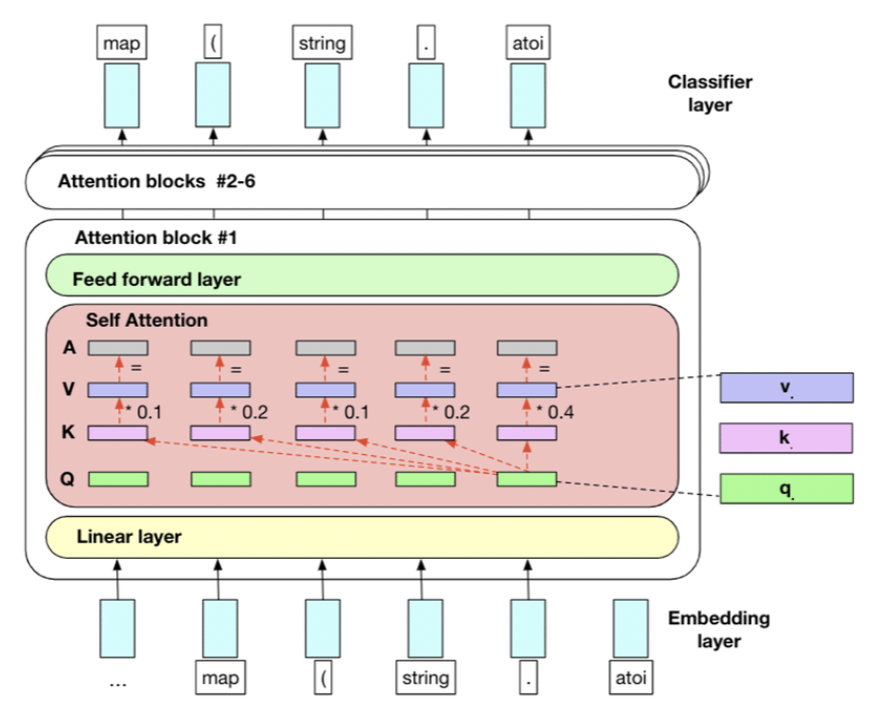

For this project, we decided to use one of the pre-trained GPT-2 models from the Hugging Face Transformers library. GPT-2, developed by OpenAI, operates with a straightforward objective: to predict the next word in a sequence based on all preceding words within a given text. This ability makes it particularly effective for tasks involving language generation and completion.

GPT-2 is based on the Transformer architecture, which has traditional recurrent layers in favor of multi-headed self-attention mechanisms. This design allows GPT-2 to process all input tokens simultaneously, leading to highly efficient training and inference phases.

While the fully trained versions of GPT models are not publicly available due to potential misuse concerns, Hugging Face offers several variants of GPT-2 that have been pre-trained on diverse datasets. The specific model size impacts both the performance and the computational demands and for our use case, we decided to train of the GPT-2 Large. Other models available are:

*   GPT-2 Small: 124 million parameters
*   GPT-2 Medium: 355 million parameters
*   GPT-2 Large: 774 million parameters
*   GPT-2 XL: 1.5 billion parameters









**Importing Data and Exploration**

In [4]:
# Mounting the Collab
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = []
dir = '/content/drive/MyDrive/NLP/'

for filename in os.listdir(dir):
  if 'Articles' in filename:
        print("File being used :" , filename)
        filepath = os.path.join(dir, filename)
        df.append(pd.read_csv(filepath))

article_df = pd.concat(df, ignore_index=True)

File being used : ArticlesApril2017.csv
File being used : ArticlesApril2018.csv
File being used : ArticlesFeb2018.csv
File being used : ArticlesMarch2018.csv
File being used : ArticlesMay2017.csv
File being used : ArticlesJan2018.csv
File being used : ArticlesFeb2017.csv
File being used : ArticlesMarch2017.csv
File being used : ArticlesJan2017.csv


In [5]:
article_df.head()

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,58def1347c459f24986d7c80,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
1,NaN,58def3237c459f24986d7c84,823,By GAIL COLLINS,article,"And Now, the Dreaded Trump Curse","['United States Politics and Government', 'Tru...",3,OpEd,23,2017-04-01 00:23:58,Unknown,Meet the gang from under the bus.,The New York Times,Op-Ed,https://www.nytimes.com/2017/03/31/opinion/and...
2,NaN,58def9f57c459f24986d7c90,575,By THE EDITORIAL BOARD,article,Venezuela’s Descent Into Dictatorship,"['Venezuela', 'Politics and Government', 'Madu...",3,Editorial,22,2017-04-01 00:53:06,Unknown,A court ruling annulling the legislature’s aut...,The New York Times,Editorial,https://www.nytimes.com/2017/03/31/opinion/ven...
3,NaN,58defd317c459f24986d7c95,1374,By MICHAEL POWELL,article,Stain Permeates Basketball Blue Blood,"['Basketball (College)', 'University of North ...",3,Sports,1,2017-04-01 01:06:52,College Basketball,"For two decades, until 2013, North Carolina en...",The New York Times,News,https://www.nytimes.com/2017/03/31/sports/ncaa...
4,NaN,58df09b77c459f24986d7ca7,708,By DEB AMLEN,article,Taking Things for Granted,['Crossword Puzzles'],3,Games,0,2017-04-01 02:00:14,Unknown,In which Howard Barkin and Will Shortz teach u...,The New York Times,News,https://www.nytimes.com/2017/03/31/crosswords/...


In [6]:
article_df.shape

(9335, 16)

In [7]:
article_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   abstract          167 non-null    object
 1   articleID         9335 non-null   object
 2   articleWordCount  9335 non-null   int64 
 3   byline            9335 non-null   object
 4   documentType      9335 non-null   object
 5   headline          9335 non-null   object
 6   keywords          9335 non-null   object
 7   multimedia        9335 non-null   int64 
 8   newDesk           9335 non-null   object
 9   printPage         9335 non-null   int64 
 10  pubDate           9335 non-null   object
 11  sectionName       9335 non-null   object
 12  snippet           9335 non-null   object
 13  source            9335 non-null   object
 14  typeOfMaterial    9335 non-null   object
 15  webURL            9335 non-null   object
dtypes: int64(3), object(13)
memory usage: 1.1+ MB


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

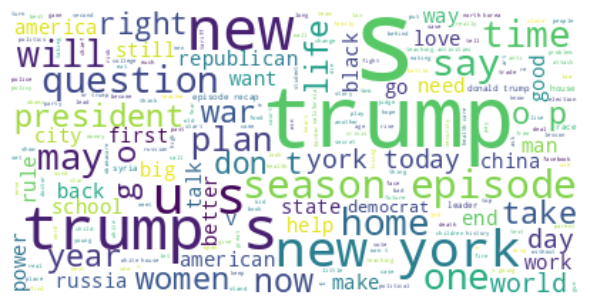

In [28]:
def clean_text(text):
    # Normalize text by converting to lowercase and removing non-alphanumeric characters
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

def generate_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                       title=None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    additional_words = {'unknown', 'Unknown', 'article'}
    stopwords.update(additional_words)

    # Cleaning to normalize the data
    text = clean_text(text)

    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42,
                          mask=mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)

    if image_color and mask is not None:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        plt.imshow(wordcloud, interpolation="bilinear")

    if title:
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

headlines = ' '.join(article_df['headline'].dropna().tolist())
generate_wordcloud(headlines, max_words=500, max_font_size=80, figure_size=(6,4))


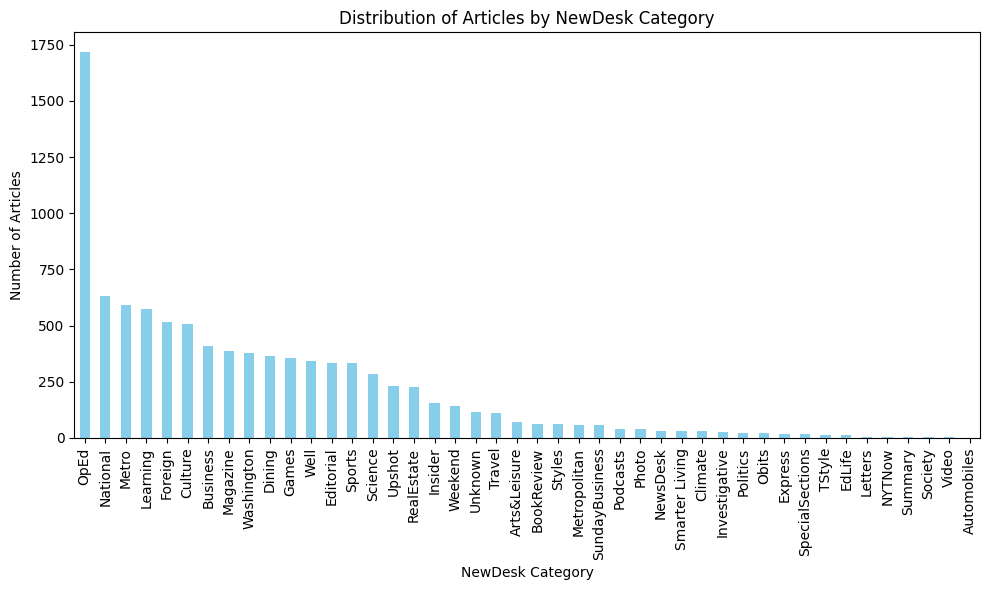

In [35]:
category_counts = article_df['newDesk'].value_counts()


plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Distribution of Articles by NewDesk Category')
plt.xlabel('NewDesk Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


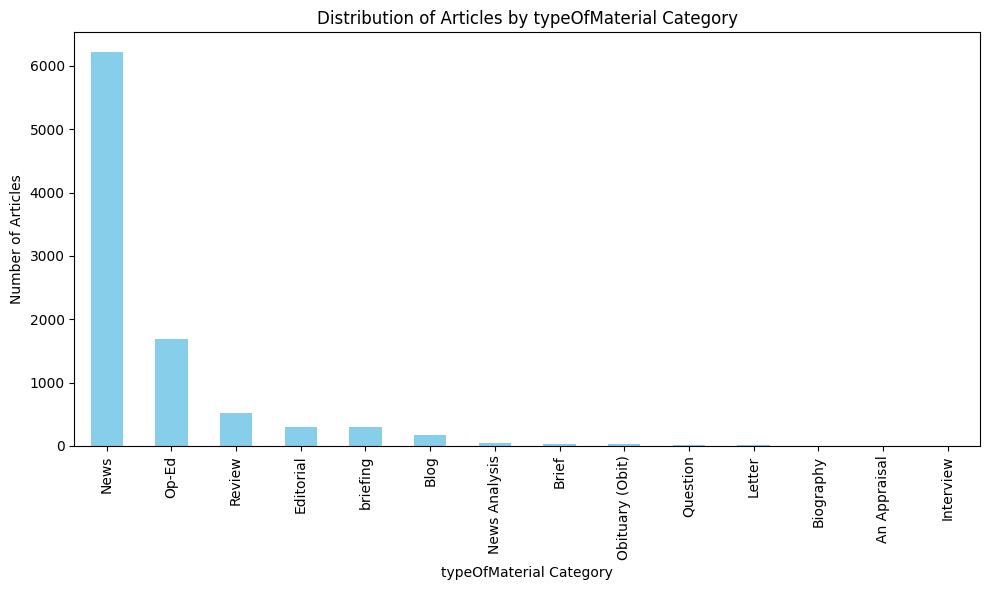

In [39]:
category_counts = article_df['typeOfMaterial'].value_counts()


plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Distribution of Articles by typeOfMaterial Category')
plt.xlabel('typeOfMaterial Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


In [55]:
all_keywords = [keyword for sublist in article_df['keywords'] for keyword in sublist]

# Convert the list of keywords to a single string
keywords_string = ''.join(all_keywords).lower()
keywords_string = re.sub(r"[^a-zA-Z0-9 ]", "", keywords_string)

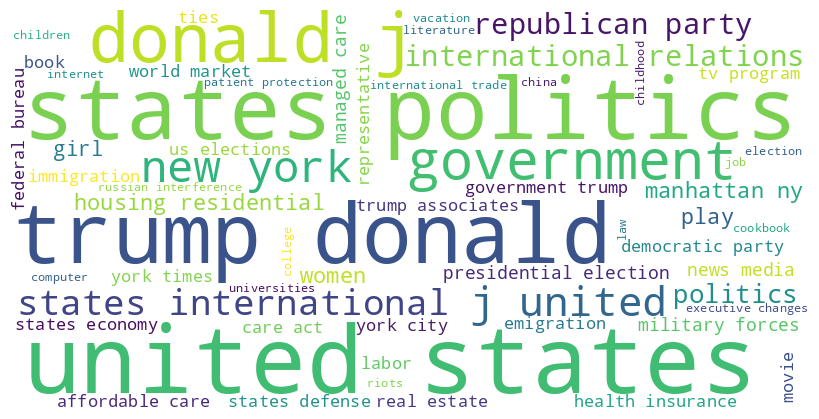

In [57]:
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=set(STOPWORDS),
                      min_font_size=10).generate(keywords_string)

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Data Preprocessing**

In [5]:
# Importing and processing the dataset
dir = '/content/drive/MyDrive/NLP/'

# Concatenating all the files that contain Article Information
headlines = []

for filename in os.listdir(dir):
  if 'Articles' in filename:
        print("File being used :" , filename)
        article_df = pd.read_csv(dir + filename)
        headlines.extend(list(article_df.headline.values))

# Ensuring keeping a track of unknown columns so that they can be removed
count_unknown = 0
all_headlines = []
for h in headlines:
  if h != "Unknown":
    all_headlines.append(h)
  else:
    count_unknown += 1

print("Count of unknown columns :", count_unknown)
print("Total number of headlines :", len(all_headlines))


File being used : ArticlesApril2017.csv
File being used : ArticlesApril2018.csv
File being used : ArticlesFeb2018.csv
File being used : ArticlesMarch2018.csv
File being used : ArticlesMay2017.csv
File being used : ArticlesJan2018.csv
File being used : ArticlesFeb2017.csv
File being used : ArticlesMarch2017.csv
File being used : ArticlesJan2017.csv
Count of unknown columns : 732
Total number of headlines : 8603


In [59]:
# Printing the data
all_headlines[:10]

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan']

In [6]:
# Cleaning the dataset

def clean(text):
    toReturn = "".join(line.lower() for line in text if line not in string.punctuation)
    toReturn = toReturn.encode("utf8").decode("ascii", 'ignore')
    return toReturn

clean_headlines = [clean(i) for i in all_headlines]
clean_headlines[:10]

['finding an expansive view  of a forgotten people in niger',
 'and now  the dreaded trump curse',
 'venezuelas descent into dictatorship',
 'stain permeates basketball blue blood',
 'taking things for granted',
 'the caged beast awakens',
 'an everunfolding story',
 'oreilly thrives as settlements add up',
 'mouse infestation',
 'divide in gop now threatens trump tax plan']

**Splitting the dataset into test and train**

In [7]:
# Importing the required libraries
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_conversations, test_conversations = train_test_split(clean_headlines, test_size=0.2, random_state=42)

In [8]:
# Initializing the GPT2 Large model
model_name = 'gpt2-large'
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=50256)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

**Generating Responses**

**Training and Key Parameters for Text Generation with GPT-2:**

**Handling Verbose Output:** GPT-2 is designed to generate long-form content, which can lead to verbosity. This characteristic may not be ideal for tasks that require brief and concise text, such as headline generation.

**Managing Output Length:** To effectively generate shorter texts like headlines, we are controling the length of the output. This has been achieved by setting the max_length parameter, which specifies the maximum number of tokens to be generated.

**Early Stopping:** To ensure that the model stops generating text at logical end points, the early_stopping parameter is being used. This is particularly useful when combined with eos_token_id, which signifies the end-of-sequence token. Setting these parameters helps the model conclude text generation once a logical endpoint (like the end of a sentence in our case) is reached.

**Enhancing Text Quality with Beam Search:** The num_beams parameter enables beam search, which is being used so that the model considers multiple potential next words at each step of the generation process. This approach helps in selecting more optimal text sequences by comparing different paths through the model's predictive space. Using beam search can lead to higher-quality, more coherent outputs.

In [9]:
def generate_response(input_text, max_length=15, temperature=0.7, top_k=20, num_beams=5):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    attention_mask = torch.ones_like(input_ids)
    eos_token_id = tokenizer.encode("\n", add_special_tokens=False)[0]
    with torch.no_grad():
        # Changes PS: Trying num_beams for beam search and early_stopping to cut off at logical points
        output = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_k=top_k,
            num_beams=num_beams,
            early_stopping=True,
            do_sample = True,
            eos_token_id = eos_token_id
        )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

In [10]:
def to_title_case(text):
    # Words not to capitalize in titles
    exceptions = ["a", "an", "the", "and", "but", "or", "for", "nor", "on", "at", "to", "from", "by", "with", "about", "as", "into", "like", "through", "after", "over", "between", "out", "against", "during", "without", "before", "under", "around", "among"]

    # Split the text into words
    words = text.split()
    # Process each word
    title_words = [words[0].capitalize()] + [word if word in exceptions and i != len(words) - 1 else word.capitalize() for i, word in enumerate(words[1:], 1)]
    # Join the processed words back into a string
    title_case_text = " ".join(title_words)

    return title_case_text

In [11]:
def post_process_response(response):
    # Convert response to title case
    response = to_title_case(response)

    # Optionally, you could also trim overly verbose responses here, if needed
    words = response.split()
    if len(words) > 8:  # Assuming you want to limit headlines to 10 words
        response = " ".join(words[:8])

    # return response
    # response = response.split(".")[0]
    return response

In [33]:
# Creating list to store various refernces and responses
responses_list = []
model_responses = []
train_references = []
test_references = []
train_hypotheses = []
test_hypotheses = []

# Initialize empty lists to store training and testing input IDs
train_input_ids = []
test_input_ids = []

def generate_results(conversations_list, user_references, hypotheses_list):
    # Generating responses
    for conversation in conversations_list:
        context_window = []

        while True:
            user_input = input("Input reference: ")  # Entering user input

            # Exiting loop in case 'x' is entered
            if user_input.strip().lower() == 'x':
                break

            context_window.append("You: " + user_input)
            if len(context_window) > 5:
                context_window.pop(0)

            # Generating the prompt for model
            prompt = context_window[-1][4:]
            # Generating responses and picking up the first one
            # EDIT : Changed from 50 to 15
            response = generate_response(prompt, max_length=15, temperature=0.8, top_k=20)
            response_sentence = response.split('.')[0]
            # Running the post processing function on the generated repsonses to make it more readable
            response_sentence = post_process_response(response_sentence)

            print("Model:", response_sentence.strip())

            # Append to references lists in order to review output later
            user_references.append(user_input)
            hypotheses_list.append(response_sentence)
            responses_list.append(response_sentence)
            model_responses.append(response_sentence)
            # print(model_responses)

        exit_loop_input = input("Input 'exit' to stop looping, or press Enter to continue: ")
        if exit_loop_input.strip().lower() == 'exit':
            print("Exiting conversation loop.")
            break

# Calling the functing on train and test converstaions
generate_results(train_conversations, train_references, train_hypotheses)
generate_results(test_conversations, test_references, test_hypotheses)

Input reference: Donald Trump Announces
Model: Donald Trump Announces First Presidential Nomination Of Donald
Input reference: Putin Says He Has
Model: Putin Says He Has 'no Plans' to Leave
Input reference: Getting a Taste of
Model: Getting a Taste Of the World's Best Coffee
Input reference: xtortion or the
Model: Xtortion or the Use Of Force or Violence
Input reference: Extortion or the
Model: Extortion or the Threat Of Such a Charge
Input reference: x
Input 'exit' to stop looping, or press Enter to continue: exit
Exiting conversation loop.
Input reference: President Trump
Model: President Trump's Decision to Withdraw from the Paris
Input reference: The Supreme Court's Decision
Model: The Supreme Court's Decision In Citizens United V
Input reference: x
Input 'exit' to stop looping, or press Enter to continue: exit
Exiting conversation loop.


**Evaluation**

In [99]:
# Calculating the Cross-Entropy Loss for our responses

# Initialize loss and token counters
train_loss = 0
test_loss = 0
train_token = 0
test_tokens = 0

# Calculate and return the sum of cross-entropy losses between logits and ground truth token IDs
def loss_function(logits, ground_truth_ids):
    total_loss = torch.nn.functional.cross_entropy(logits, ground_truth_ids, reduction='sum')
    return total_loss

# Process both training and test sets
for references, hypotheses in zip([train_references, test_references], [train_hypotheses, test_hypotheses]):
    for reference, hypothesis in zip(references, hypotheses):
       # Convert reference and hypothesis into token IDs
        ref_ids = [tokenizer.convert_tokens_to_ids(ref) for ref in reference.split()]
        hyp_ids = [tokenizer.convert_tokens_to_ids(hyp) for hyp in hypothesis.split()]

        # Ensure that reference and hypothesis have the same length
        min_length = min(len(ref_ids), len(hyp_ids))
        ref_ids = ref_ids[:min_length]
        ref_tensor = torch.tensor(ref_ids).unsqueeze(0)

        hyp_ids = hyp_ids[:min_length]
        hyp_tensor = torch.tensor(hyp_ids).unsqueeze(0)

        # Getting the logits and calculating loss for both reference and hypothesis
        ref_logits = model(input_ids=ref_tensor).logits.squeeze(0)
        train_loss_temp = loss_function(ref_logits, torch.tensor(hyp_ids))

        hyp_logits = model(input_ids=hyp_tensor).logits.squeeze(0)
        test_loss_temp = loss_function(hyp_logits, torch.tensor(hyp_ids))

        train_loss += train_loss_temp.item()
        train_token += len(hyp_ids)
        test_loss += test_loss_temp.item()
        test_tokens += len(hyp_ids)

In [100]:
final_train_loss = train_loss / train_token
final_test_loss = test_loss / test_tokens

print(f"Average Cross-Entropy Loss for our Training Set: ", final_train_loss )
print(f"Average Cross-Entropy Loss for our Test Set: ", final_test_loss)


Average Cross-Entropy Loss for our Training Set:  8.533486466658744
Average Cross-Entropy Loss for our Test Set:  9.324660351401882


In [31]:
import math

reference_headlines = [headline.split() for headline in test_conversations]
generated_headlines = []
for headline in reference_headlines[:100]:
  length = len(headline)
  seed_words_length = math.ceil(length * 0.3)
  # generate_response(input_text, max_length=15, temperature=0.7, top_k=20, num_beams=5):
  generated_headlines.append(generate_response(headline[:seed_words_length], length , temperature=0.7, top_k=20, num_beams=5))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

In [32]:
from nltk.translate.bleu_score import corpus_bleu

bleu_score = corpus_bleu(reference_headlines[:100], generated_headlines)
print("BLEU Score:", bleu_score)

BLEU Score: 0.2501135901812588
